In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import librosa
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Softmax, Dropout, BatchNormalization, Activation

from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import keras

# Preprocessing

From generated chords, get the following:

- Chord name (A, B, C, D...)
- Chord type (major, minor, dimishished, diminished 7, etc.)
- instrument type

In [13]:
chord_filenames = glob("../../data/nsynth-train/generated_chords/*.wav")

In [14]:
len(chord_filenames)

240056

In [24]:
chord_filenames[0]

'../../data/nsynth-train/generated_chords/G#5_min7_string_acoustic_067_iter2.wav'

In [26]:
from collections import namedtuple
def get_chord_metadata_from_filename(filename):
    filename = filename.split("/")[-1]
    metadata_data = filename.split("_")
    meta = namedtuple("metadata", "chord_name chord_name_base chord_type instrument_family instrument_source instrument_key")
    out = meta(chord_name=metadata_data[0],
               chord_name_base=''.join([i for i in metadata_data[0] if not i.isdigit()]),
               chord_type=metadata_data[1],
               instrument_family=metadata_data[2],
               instrument_source=metadata_data[3],
               instrument_key="_".join(metadata_data[2:5]))
    
    return out

In [27]:
# Get metadata from each filename
metadata = [get_chord_metadata_from_filename(file) for file in tqdm(chord_filenames)]

In [28]:
metadata_df = pd.DataFrame.from_records(metadata)
metadata_df.columns = ["chord_name", "chord_name_base", "chord_type", "instrument_family", "instrument_source", "instrument_key"]
metadata_df['filename'] = chord_filenames

In [30]:
# Get counts of each of our classes
metadata_df.chord_name_base.value_counts()

D     28111
B     26900
F#    23046
A     21666
E     21129
G     20723
G#    20290
C#    19654
D#    19107
C     18126
F     13058
A#     8246
Name: chord_name_base, dtype: int64

In [105]:
metadata_df.instrument_family.value_counts()

string      112705
guitar       73553
keyboard     52688
bass          1110
Name: instrument_family, dtype: int64

# Modeling

For a first pass (faster), sample ~100000 chords and see if we can get a model to learn anything

NOTE: We need to ensure that the testing set contains new/distinct instruments that are not in the training set.  We cannot simply do metadata_df.sample(n).  We must sample n instruments from the dataset and ensure there are distinct instruments between train/test

In [33]:
unique_instrument_keys = metadata_df.instrument_key.unique()

In [40]:
unique_instrument_keys.shape[0]*.80

110.4

In [106]:
# 70% of instruments in training
# 15% of instruments in validation
# 15% of instruments in testing
train_instrument_keys = np.random.choice(unique_instrument_keys, int(unique_instrument_keys.shape[0]*.80))
remaining = unique_instrument_keys[np.where(~np.isin(unique_instrument_keys, train_instrument_keys))]
val_instrument_keys = np.random.choice(remaining, int(remaining.shape[0]*.5))
test_instrument_keys = remaining[np.where(~np.isin(remaining, val_instrument_keys))]

In [107]:
metadata_df[metadata_df.instrument_key.isin(val_instrument_keys)].instrument_family.unique()

array(['string', 'guitar', 'keyboard'], dtype=object)

In [108]:
metadata_df[metadata_df.instrument_key.isin(test_instrument_keys)].instrument_family.unique()

array(['string', 'guitar', 'keyboard'], dtype=object)

In [109]:
train_df_sample = metadata_df[metadata_df.instrument_key.isin(train_instrument_keys)]
val_df_sample = metadata_df[metadata_df.instrument_key.isin(val_instruement_keys)]
test_df_sample = metadata_df[metadata_df.instrument_key.isin(test_instrument_keys)]

In [110]:
# Import .wav files
train_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(train_df_sample.filename)]

In [111]:
val_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(val_df_sample.filename)]

In [112]:
test_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(test_df_sample.filename)]

In [113]:
import scipy.fftpack

In [114]:
# Convert all chords from time to frequency domain
train_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(train_x_input)]
train_x_fft = np.array(train_x_fft)

In [115]:
val_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(val_x_input)]
val_x_fft = np.array(val_x_fft)

In [116]:
test_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(test_x_input)]
test_x_fft = np.array(test_x_fft)

In [117]:
del(train_x_input)
del(val_x_input)
del(test_x_input)

In [118]:
# Create one hot matrix of instrument type
le_note_base = LabelEncoder()
le_note_base.fit(train_df_sample.chord_name_base)
train_y_note_base = to_categorical(le_note_base.transform(train_df_sample.chord_name_base))
val_y_note_base = to_categorical(le_note_base.transform(val_df_sample.chord_name_base))
test_y_note_base = to_categorical(le_note_base.transform(test_df_sample.chord_name_base))

le_instrument_family = LabelEncoder()
le_instrument_family.fit(train_df_sample.instrument_family)
train_y_instrument_family = to_categorical(le_instrument_family.transform(train_df_sample.instrument_family))
val_y_instrument_family = to_categorical(le_instrument_family.transform(val_df_sample.instrument_family))
test_y_instrument_family = to_categorical(le_instrument_family.transform(test_df_sample.instrument_family))

le_chord_type = LabelEncoder()
le_chord_type.fit(train_df_sample.chord_type)
train_y_chord_type = to_categorical(le_chord_type.transform(train_df_sample.chord_type))
val_y_chord_type = to_categorical(le_chord_type.transform(val_df_sample.chord_type))
test_y_chord_type = to_categorical(le_chord_type.transform(test_df_sample.chord_type))

## Chord Classification

In [119]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(12, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 8000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                400050    
_________________________________________________________________
batch_normalization_25 (Batc (None, 50)                200       
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_26 (Batc (None, 50)                200       
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_27 (Batc (None, 50)                200       
__________

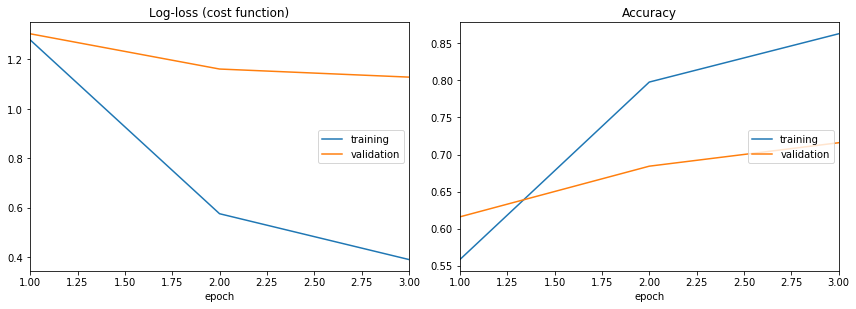

In [121]:
history = model.fit([train_x_fft],
                    train_y_note_base,
                    epochs=3,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_note_base),
                    callbacks=[PlotLossesKeras()])

In [122]:
# Test set predictions
model.evaluate(test_x_fft, test_y_note_base)

  384/54476 [..............................] - ETA: 26s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 31s 562us/step


[2.315313595280842, 0.4778250972883617]

## Instrument type classification

In [123]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(4, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

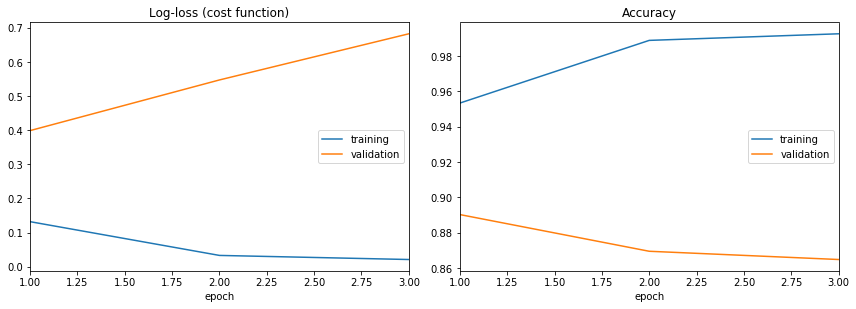

In [124]:
history = model.fit([train_x_fft],
                    train_y_instrument_family,
                    epochs=3,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_instrument_family),
                    callbacks=[PlotLossesKeras()])

In [125]:
model.evaluate(test_x_fft, test_y_instrument_family)

  544/54476 [..............................] - ETA: 17s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 27s 493us/step


[3.143201933049606, 0.53054556134374]

We can predict our 4 initial instrument families (guitar, piano, strings, bass) with ~99% accuracy.  This instruments are fairly distinct from one another.  Would we expect our accuracy to decrease as we introduce more obscure instrument families into the dataset?

## Chord Type

In [126]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
lay1 = Dropout(.5)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
lay2 = Dropout(.5)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
lay3 = Dropout(.5)(lay3)

output = Dense(13, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

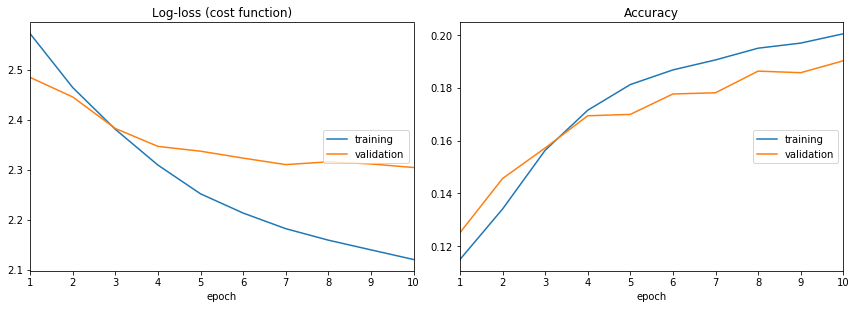

In [127]:
history = model.fit([train_x_fft],
                    train_y_chord_type,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_chord_type),
                    callbacks=[PlotLossesKeras()])

In [128]:
model.evaluate(test_x_fft, test_y_chord_type)

  512/54476 [..............................] - ETA: 19s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 27s 501us/step


[2.644049613501534, 0.14231955356541967]

Predicting the chord type (maj, min, dim, aug, etc.) appears to be a bit more difficult than the other categories. 

I wonder if this is due to more sparsity in these classes than in the others.  I suspect we may see gains here when we run with more data.

## Multi-output (predict all the predictors above in one neural net)

In [139]:
in_data = Input(shape=(8000, ))

lay1 = Dense(20, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
lay1 = Dropout(.4)(lay1)

lay2 = Dense(20, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
lay2 = Dropout(.4)(lay2)

# lay3 = Dense(50, activation='relu')(lay2)
# lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.4)(lay3)

output_chord_note_base = Dense(12, activation = "softmax")(lay2)
output_instrument_family = Dense(4, activation = "softmax")(lay2)
output_chord_type = Dense(13, activation = "softmax")(lay2)

model = Model(inputs=[in_data],
              outputs=[output_chord_note_base, output_instrument_family, output_chord_type])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

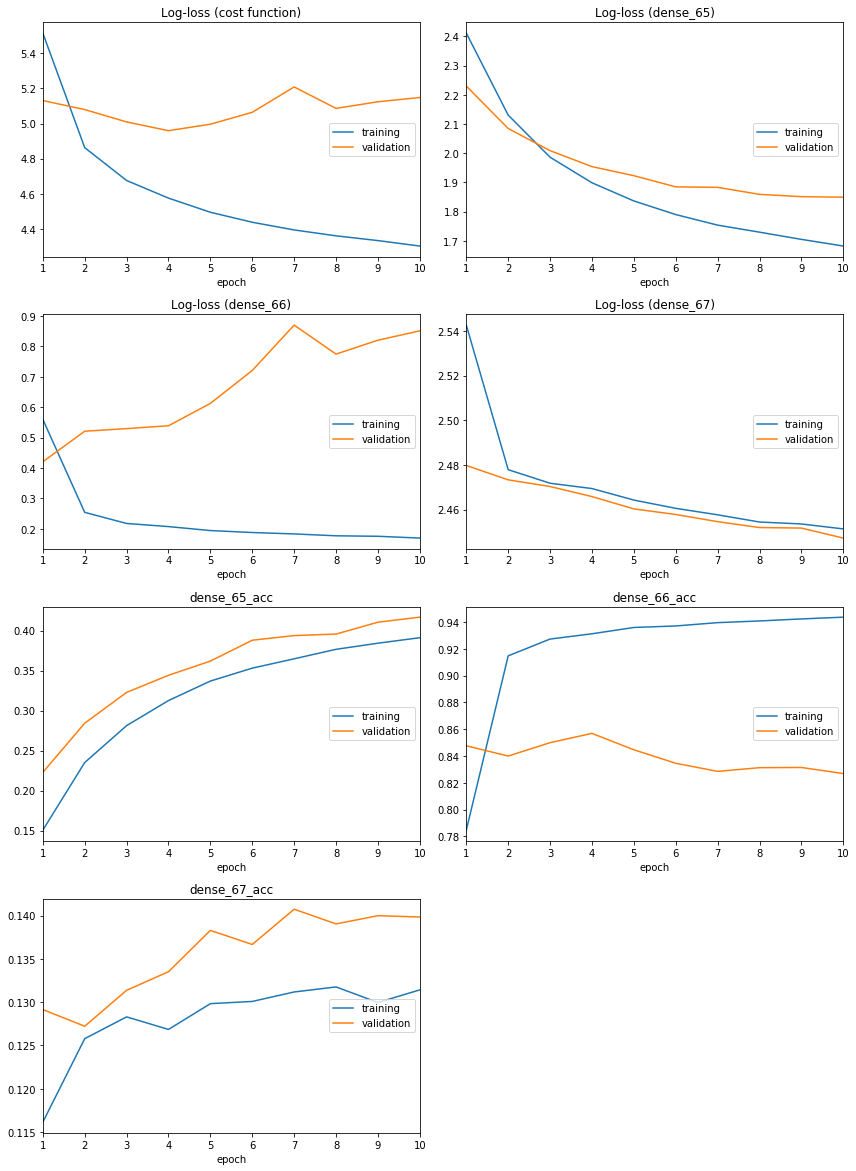

In [140]:
history = model.fit([train_x_fft],
                    [train_y_note_base, train_y_instrument_family, train_y_chord_type],
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x_fft, [val_y_note_base, val_y_instrument_family, val_y_chord_type]),
                    callbacks=[PlotLossesKeras()])

In [141]:
model.evaluate(test_x_fft, [test_y_note_base, test_y_instrument_family, test_y_chord_type])

  608/54476 [..............................] - ETA: 15s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 22s 410us/step


[8.222284226894063,
 2.6779054772075694,
 3.0614208979214137,
 2.4829578451476912,
 0.21987664292587197,
 0.4816800058763347,
 0.1241647698074345]

# TO DOs:

- Generate chords for more instruments and see if we can still get high accuracy when we increase that
- Potentially play with more instrument sources.  All these chords are from acoustic instrumentation, but we can generate data from "synthetic" as well as "electronic" instrumentation as well
- Run model with all data and see if we can push accuracy further
- Play around more with model architecture and see if that does anything.  I completely 100% arbitrarily selected the one I used. 

# Model with Chris' recordings

In [31]:
cd ../

/Users/mattgraziano/Google Drive/Documents/Learning/IU/Fall18/engr511/project/engr511


## Import data

In [36]:
recording_filenames = glob("data/recordings/*/*.wav", recursive=True)

In [215]:
from src.Progression_Modeling import Load, Prepare, Mel_transform, normalize, melspectrogram, trim
import soundfile as sf

In [70]:
A0 = 27.5
C2 = 65.41
C7 = 2093.00
C8 = 4186.01

In [123]:
def nth_largest_col_sum(arr, n=-80):
    # column sum
    agg = np.sum(arr, axis=0)
    agg.sort()
    return agg[n]
    

In [273]:
def get_spectrogram(signal, sr=44100):
    spectrogram = melspectrogram(Prepare(signal), sr=sr, fmin=C2, fmax=C7, n_fft=2048 * 2, hop_length=1024)
    spectrogram_norm = pow(normalize(spectrogram), .25)
    return spectrogram_norm

In [291]:
def get_clean_x(signal, sr=44100, nth_largest=-45):
    spectrogram = get_spectrogram(signal, sr=sr)

    # Get 45th largest value
    nth_largest_threshold = nth_largest_col_sum(spectrogram, nth_largest)

    # remove all columsn whose sum is less than t
    clean = spectrogram[:, np.sum(spectrogram, axis=0) >= nth_largest_threshold]
    
    return clean

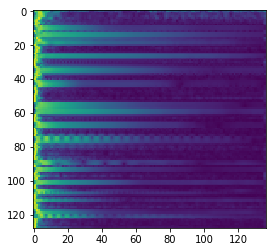

In [284]:
a = get_spectrogram(sf.read(recording_filenames[16])[0])
plt.imshow(a)

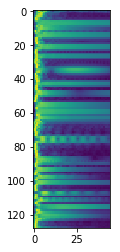

In [297]:
plt.imshow(get_clean_x(sf.read(recording_filenames[50])[0]))

In [395]:
raw_signals = []
samp_rates = []
x_train = []
for filename in recording_filenames:
    sound, sr = sf.read(filename)
    
    raw_signals.append(sound)
    samp_rates.append(sr)
    cleaned = get_clean_x(sound, sr=sr, nth_largest=-1)
    x_train.append(cleaned.flatten())
    

In [396]:
x_train = np.vstack(x_train)

In [392]:
sound, sr = sf.read("../data/nsynth-train/generated_chords_single_foursec/A#1_dim7_guitar_acoustic_003_iter0.wav", -16)

In [352]:
testest_sound, sr = sf.read("../data/nsynth-train/generated_chords_single_foursec/A#1_dim_keyboard_acoustic_013_iter0.wav")

In [362]:
test = get_clean_x(test_sound, sr=sr, nth_largest=-1)

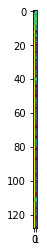

In [361]:
plt.imshow(test)

In [170]:
# Flatten spectrogram for input into neural net
x_train = np.array([i.flatten() for i in spectrogram_cleaned])

In [226]:
x_train.shape

(59,)

In [383]:
y_train_int

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [382]:
y_train

['dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'dim',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Maj7',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min',
 'Min']

In [397]:
# Get y categories
y_train = [i.split('/')[2] for i in recording_filenames]

le_chord_structure = LabelEncoder()
le_chord_structure.fit(y_train)
y_train_int = to_categorical(le_chord_structure.transform(y_train))


## Modeling:

In [398]:
in_data = Input(shape=(x_train.shape[1], ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)

output = Dense(y_train_int.shape[1], activation = "softmax")(lay2)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

In [399]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                6450      
_________________________________________________________________
batch_normalization_17 (Batc (None, 50)                200       
_________________________________________________________________
dense_25 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_18 (Batc (None, 50)                200       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 204       
Total params: 9,604
Trainable params: 9,404
Non-trainable params: 200
_________________________________________________________________


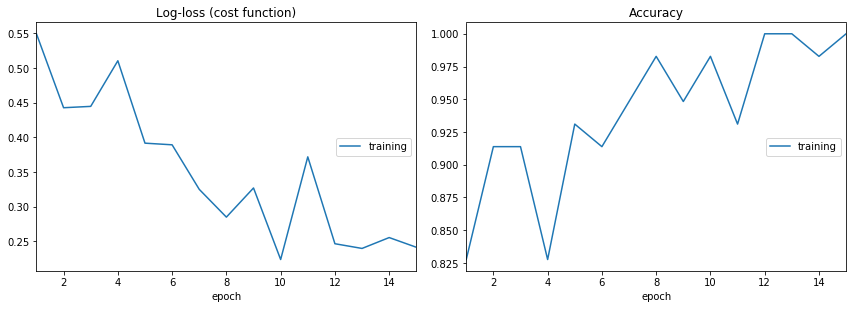

In [401]:
history = model.fit([x_train],
                    [y_train_int],
                    epochs=15,
                    batch_size=16,
                    callbacks=[PlotLossesKeras()])

In [385]:
model.evaluate(x=x_train, y=y_train_int)

59/59 [==============================] - 0s 4ms/step


[0.3285976870585296, 0.949152545403626]

### Make a holdout pred (1 sample)

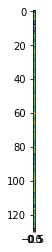

In [402]:
test_sound, sr = sf.read("../data/nsynth-train/generated_chords_single_foursec/A#1_dim_keyboard_acoustic_013_iter0.wav")
test = get_clean_x(test_sound, sr=sr, nth_largest=-1)

plt.imshow(test)

In [403]:
model.predict(test.T)

array([[0.48755288, 0.4948804 , 0.00444806, 0.0131187 ]], dtype=float32)

In [405]:
test_sound, sr = sf.read(filename)
test_cleaned = get_clean_x(test_sound, sr=sr, nth_largest=-1)

In [407]:
model.predict(test_cleaned.T)

array([[0.72911024, 0.21637875, 0.03861705, 0.01589403]], dtype=float32)

In [404]:
y_train[0]

'dim'